# Data Collection

In [1]:
!pip install kaggle

import json
import zipfile
import os

In [9]:
from google.colab import drive 

drive.mount('/content/drive')
os.chdir("/content/drive/Shared drives/UTMSBA APM Pneumonia")

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
kaggle.json


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip -q chest-xray-pneumonia.zip -d .

replace ./chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: test
error:  invalid response [test]
replace ./chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace ./chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: all
error:  invalid response [all]
replace ./chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: [A]ll
error:  invalid response [[A]ll]
replace ./chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Read

In [10]:
from google.colab import drive 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

drive.mount('/content/drive')
os.chdir("/content/drive/Shared drives/UTMSBA APM Pneumonia")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
train_dir = "/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/train"
test_dir = "/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/test"
val_dir = "/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/val"

In [14]:
batch_size = 32
img_height = 300
img_width = 300
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 16 files belonging to 2 classes.


# Inital Descriptive Analysis (number of sets/images/etc)

In [32]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import pandas as pd
import seaborn as sns

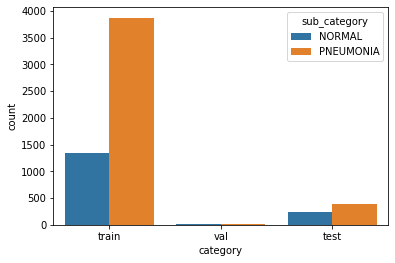

In [35]:
category_list=["train","val","test"]
sub_category_list=["NORMAL","PNEUMONIA"]
path_template="/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/{}/{}/*.jpeg"
category_list_df=[]
sub_category_list_df=[]
count_list_df=[]
for category in category_list:
    for sub_category in sub_category_list:
        path_full=path_template.format(category,sub_category)
        category_list_df.append(category)
        sub_category_list_df.append(sub_category)
        count_list_df.append(len(glob(path_full)))
pic_count_df=pd.DataFrame({'category':category_list_df,'sub_category':sub_category_list_df,'count':count_list_df})    
sns.barplot(x="category", y="count", hue="sub_category", data=pic_count_df)

We have way more images that are classified as pneumonia than normal. This shows that we have a imbalance in our data.

This situation is very normal when it comes to medical data. The data will always be imbalanced. either there will be too many normal cases or there will be too many cases with the disease.



In [36]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")


Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


In [37]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.imshow(img)

    plt.tight_layout()

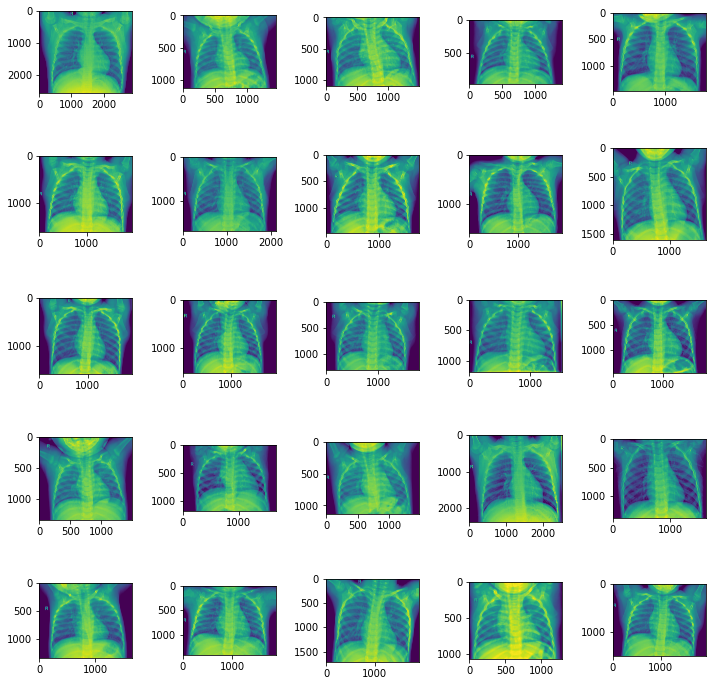

In [40]:
dirname='/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray'
train_path = os.path.join(dirname,'/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/train')
train_nrml_pth = os.path.join(train_path, 'NORMAL')
train_pnm_pth = os.path.join(train_path, 'PNEUMONIA')
plot_imgs(train_nrml_pth)

Some photos of healthy people.

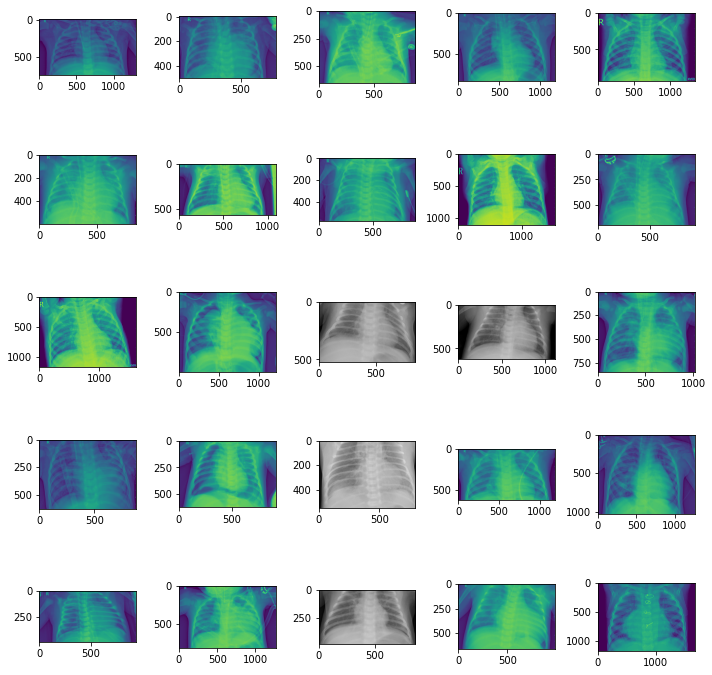

In [41]:
plot_imgs(train_pnm_pth)

Some photos of sick patients.

The dimensions of the image are 2534 pixels width and 2890 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 135.4134 and the standard deviation is 58.7444


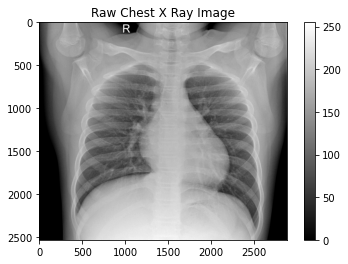

In [43]:
normal_img = os.listdir("/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/train/NORMAL")[0]
normal_dir = "/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

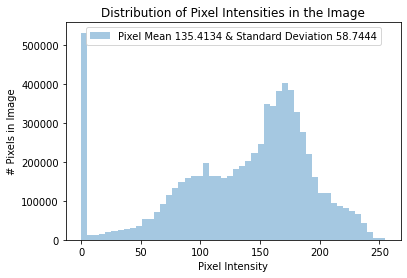

In [44]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [45]:
from tqdm import tqdm
from multiprocessing import Pool
import imageio
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
def extract_image_props(impath):
    label = "NORMAL"
    if impath.find('_bacteria_')>0:
        label = 'BACTERIA'
    elif impath.find('_virus_')>0:
        label = 'VIRUS'   
    im = imageio.imread(impath)
    br_med = np.median(im)
    br_std = np.std(im)
    xsize = im.shape[1]
    ysize = im.shape[0]
    datasplit = "train"
    if impath.find('test')>0:
        datasplit = 'test'
    elif impath.find('val')>0:
        datasplit = 'val'
    return datasplit, impath, label, xsize, ysize, br_med, br_std

In [52]:
BASE_DIR="/content/drive/Shared drives/UTMSBA APM Pneumonia/chest_xray/chest_xray"
impaths = tf.io.gfile.glob([BASE_DIR + '/*/*/*.jpeg', ])
with open("train_image_props.csv","w+") as f:
    f.write("datasplit,impath,label,xsize,ysize,br_med,br_std\n")
    for i in range(len(impaths)):
        if i%100 == 0:
            print(i)
        p=impaths[i]
        datasplit, impath, label, xsize, ysize, br_med, br_std=extract_image_props(p)
        f.write("{},{},{},{},{},{},{}\n".format(datasplit, impath, label, xsize, ysize, br_med, br_std))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800


In [53]:
train_image_props=pd.read_csv("train_image_props.csv")

In [57]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, 
                     scatter_alpha=.5, globalhist=False):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter
    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df,
        height=8
    )
    g.set_axis_labels('Width', 'Height')
    
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
            kde=False
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True,
            kde=False
        )
    # Do also global Hist:
    if globalhist:
        sns.distplot(
            df[col_x].values,
            ax=g.ax_marg_x,
            color='grey'
        )
        sns.distplot(
            df[col_y].values.ravel(),
            ax=g.ax_marg_y,
            color='grey',
            vertical=True
        )
    plt.legend(legends)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


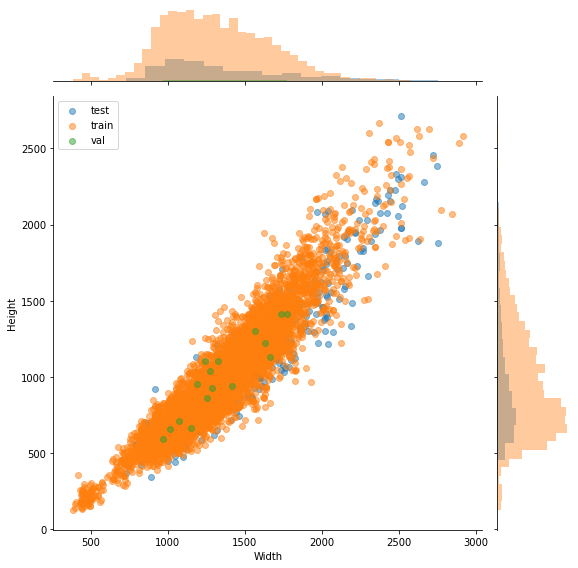

In [55]:
multivariateGrid('xsize', 'ysize', 'datasplit', df=train_image_props)

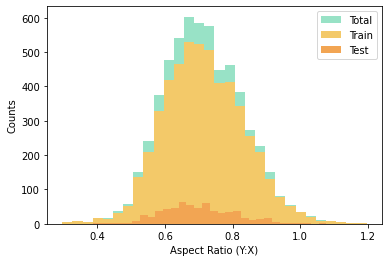

In [56]:
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
train_image_props['aspectratio_yx'] = train_image_props.ysize / train_image_props.xsize
train_image_props.aspectratio_yx.hist(bins=30, grid=False, color=custom_colors[2])
train_image_props[train_image_props.datasplit == 'train'].aspectratio_yx.hist(bins=30, grid=False, color=custom_colors[3])
train_image_props[train_image_props.datasplit == 'test'].aspectratio_yx.hist(bins=30, grid=False, color=custom_colors[4])
plt.legend(['Total', 'Train', 'Test'])
plt.xlabel('Aspect Ratio (Y:X)')
plt.ylabel('Counts')
plt.show()